In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_DIR = './models'
DATA_DIR = './data'
RESULT_DIR = './results'
BATCH_SIZE = 128

# PGD Attack Parameters
PGD_EPS = 0.03        # Maximum perturbation (same as FGSM)
PGD_ALPHA = 0.01      # Step size per iteration
PGD_STEPS = 10        # Number of iterations

# FGSM for comparison
FGSM_EPS = 0.03

CIFAR10_CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(" Libraries imported")
print(f"Device: {DEVICE}")
print(f"\nPGD Attack Configuration:")
print(f"  • Epsilon (max perturbation): {PGD_EPS}")
print(f"  • Alpha (step size): {PGD_ALPHA}")
print(f"  • Steps (iterations): {PGD_STEPS}")


 Libraries imported
Device: cpu

PGD Attack Configuration:
  • Epsilon (max perturbation): 0.03
  • Alpha (step size): 0.01
  • Steps (iterations): 10


In [7]:
# ==================== LOAD MODEL ====================

print("Loading trained model...")

model = models.resnet18(num_classes=10)
model.load_state_dict(torch.load('./models/baseline_resnet18_best.pth', map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

print(" Model loaded successfully")

# ==================== LOAD DATA ====================

print("Loading test data...")

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                       (0.2023, 0.1994, 0.2010))
])

test_dataset = datasets.CIFAR10(
    root=DATA_DIR, 
    train=False, 
    download=False,
    transform=transform_test
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f" Test data loaded: {len(test_dataset)} samples")


Loading trained model...
 Model loaded successfully
Loading test data...
 Test data loaded: 10000 samples


In [8]:
# ==================== FGSM ATTACK (for comparison) ====================

def fgsm_attack(model, images, labels, eps=0.03):
    """Fast Gradient Sign Method - One step attack"""
    images = images.clone().detach().to(DEVICE)
    labels = labels.to(DEVICE)
    images.requires_grad = True
    
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    
    model.zero_grad()
    loss.backward()
    
    data_grad = images.grad.data
    adversarial_images = images + eps * data_grad.sign()
    adversarial_images = torch.clamp(adversarial_images, 0, 1)
    
    return adversarial_images.detach()


# ==================== PGD ATTACK (stronger) ====================

def pgd_attack(model, images, labels, eps=0.03, alpha=0.01, steps=10):
    """
    Projected Gradient Descent Attack
    
    How it works:
    1. Start with random perturbation
    2. For each iteration:
       - Compute gradient
       - Take small step in gradient direction (alpha)
       - Project back to epsilon ball (stay within bounds)
    3. Result: Much stronger attack than FGSM!
    
    Args:
        model: Neural network
        images: Input images
        labels: True labels
        eps: Maximum perturbation (0.03)
        alpha: Step size per iteration (0.01)
        steps: Number of iterations (10)
    
    Returns:
        adversarial_images: Attacked images
    """
    
    images = images.clone().detach().to(DEVICE)
    labels = labels.to(DEVICE)
    
    # Start with random perturbation within epsilon ball
    delta = torch.zeros_like(images, requires_grad=False)
    delta.uniform_(-eps, eps)
    delta.data = torch.clamp(images.data + delta.data, 0, 1) - images.data
    
    # Iteratively perturb
    for step in range(steps):
        delta.requires_grad = True
        
        # Forward pass
        outputs = model(images + delta)
        loss = F.cross_entropy(outputs, labels)
        
        # Backward pass
        model.zero_grad()
        loss.backward()
        
        # Update perturbation
        grad = delta.grad.detach()
        delta = delta.detach() + alpha * grad.sign()
        
        # Project back to epsilon ball
        delta = torch.clamp(delta, -eps, eps)
        delta = torch.clamp(images + delta, 0, 1) - images
    
    adversarial_images = images + delta
    
    return adversarial_images.detach()


print(" FGSM attack function defined")
print(" PGD attack function defined")
print(f"\nKey Difference:")
print(f"  • FGSM: 1 step, fast but weak")
print(f"  • PGD:  {PGD_STEPS} steps, slower but MUCH stronger")


 FGSM attack function defined
 PGD attack function defined

Key Difference:
  • FGSM: 1 step, fast but weak
  • PGD:  10 steps, slower but MUCH stronger


In [5]:
# ==================== EVALUATE CLEAN + FGSM + PGD ====================

print("\n" + "="*60)
print("EVALUATING: CLEAN vs FGSM vs PGD")
print("="*60 + "\n")

clean_correct = 0
fgsm_correct = 0
pgd_correct = 0
total = 0

# Storage for visualization
attack_samples = None

model.eval()

for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc='Testing all attacks')):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    
    # 1. Clean predictions
    with torch.no_grad():
        outputs_clean = model(images)
        _, pred_clean = outputs_clean.max(1)
        clean_correct += (pred_clean == labels).sum().item()
    
    # 2. FGSM attack
    fgsm_images = fgsm_attack(model, images, labels, eps=FGSM_EPS)
    with torch.no_grad():
        outputs_fgsm = model(fgsm_images)
        _, pred_fgsm = outputs_fgsm.max(1)
        fgsm_correct += (pred_fgsm == labels).sum().item()
    
    # 3. PGD attack
    pgd_images = pgd_attack(model, images, labels, eps=PGD_EPS, alpha=PGD_ALPHA, steps=PGD_STEPS)
    with torch.no_grad():
        outputs_pgd = model(pgd_images)
        _, pred_pgd = outputs_pgd.max(1)
        pgd_correct += (pred_pgd == labels).sum().item()
    
    total += labels.size(0)
    
    # Store first batch for visualization
    if batch_idx == 0:
        attack_samples = {
            'clean': images[:8].cpu(),
            'fgsm': fgsm_images[:8].cpu(),
            'pgd': pgd_images[:8].cpu(),
            'labels': labels[:8].cpu(),
            'pred_clean': pred_clean[:8].cpu(),
            'pred_fgsm': pred_fgsm[:8].cpu(),
            'pred_pgd': pred_pgd[:8].cpu()
        }

# Calculate accuracies
clean_accuracy = 100 * clean_correct / total
fgsm_accuracy = 100 * fgsm_correct / total
pgd_accuracy = 100 * pgd_correct / total

print(f"\n{'='*60}")
print("RESULTS - ATTACK COMPARISON")
print(f"{'='*60}")
print(f"Clean Accuracy:      {clean_accuracy:.2f}%  ← Baseline")
print(f"FGSM Accuracy:       {fgsm_accuracy:.2f}%  ← Drop: {clean_accuracy - fgsm_accuracy:.2f}%")
print(f"PGD Accuracy:        {pgd_accuracy:.2f}%  ← Drop: {clean_accuracy - pgd_accuracy:.2f}%")
print(f"{'='*60}")

print(f"\n Key Observation:")
print(f"  PGD is STRONGER than FGSM!")
print(f"  • FGSM dropped accuracy by {clean_accuracy - fgsm_accuracy:.1f}%")
print(f"  • PGD dropped accuracy by {clean_accuracy - pgd_accuracy:.1f}%")
print(f"  • PGD is {(clean_accuracy - pgd_accuracy) - (clean_accuracy - fgsm_accuracy):.1f}% more effective!")



EVALUATING: CLEAN vs FGSM vs PGD



Testing all attacks: 100%|███████████████████████████████████████████████████████████████| 79/79 [22:38<00:00, 17.19s/it]


RESULTS - ATTACK COMPARISON
Clean Accuracy:      81.75%  ← Baseline
FGSM Accuracy:       35.25%  ← Drop: 46.50%
PGD Accuracy:        23.69%  ← Drop: 58.06%

 Key Observation:
  PGD is STRONGER than FGSM!
  • FGSM dropped accuracy by 46.5%
  • PGD dropped accuracy by 58.1%
  • PGD is 11.6% more effective!


Creating comparison visualization...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.404196].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.9139996].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.757137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.527882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.63949].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.6651373].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.8747845].
Clipping input data to the valid range 

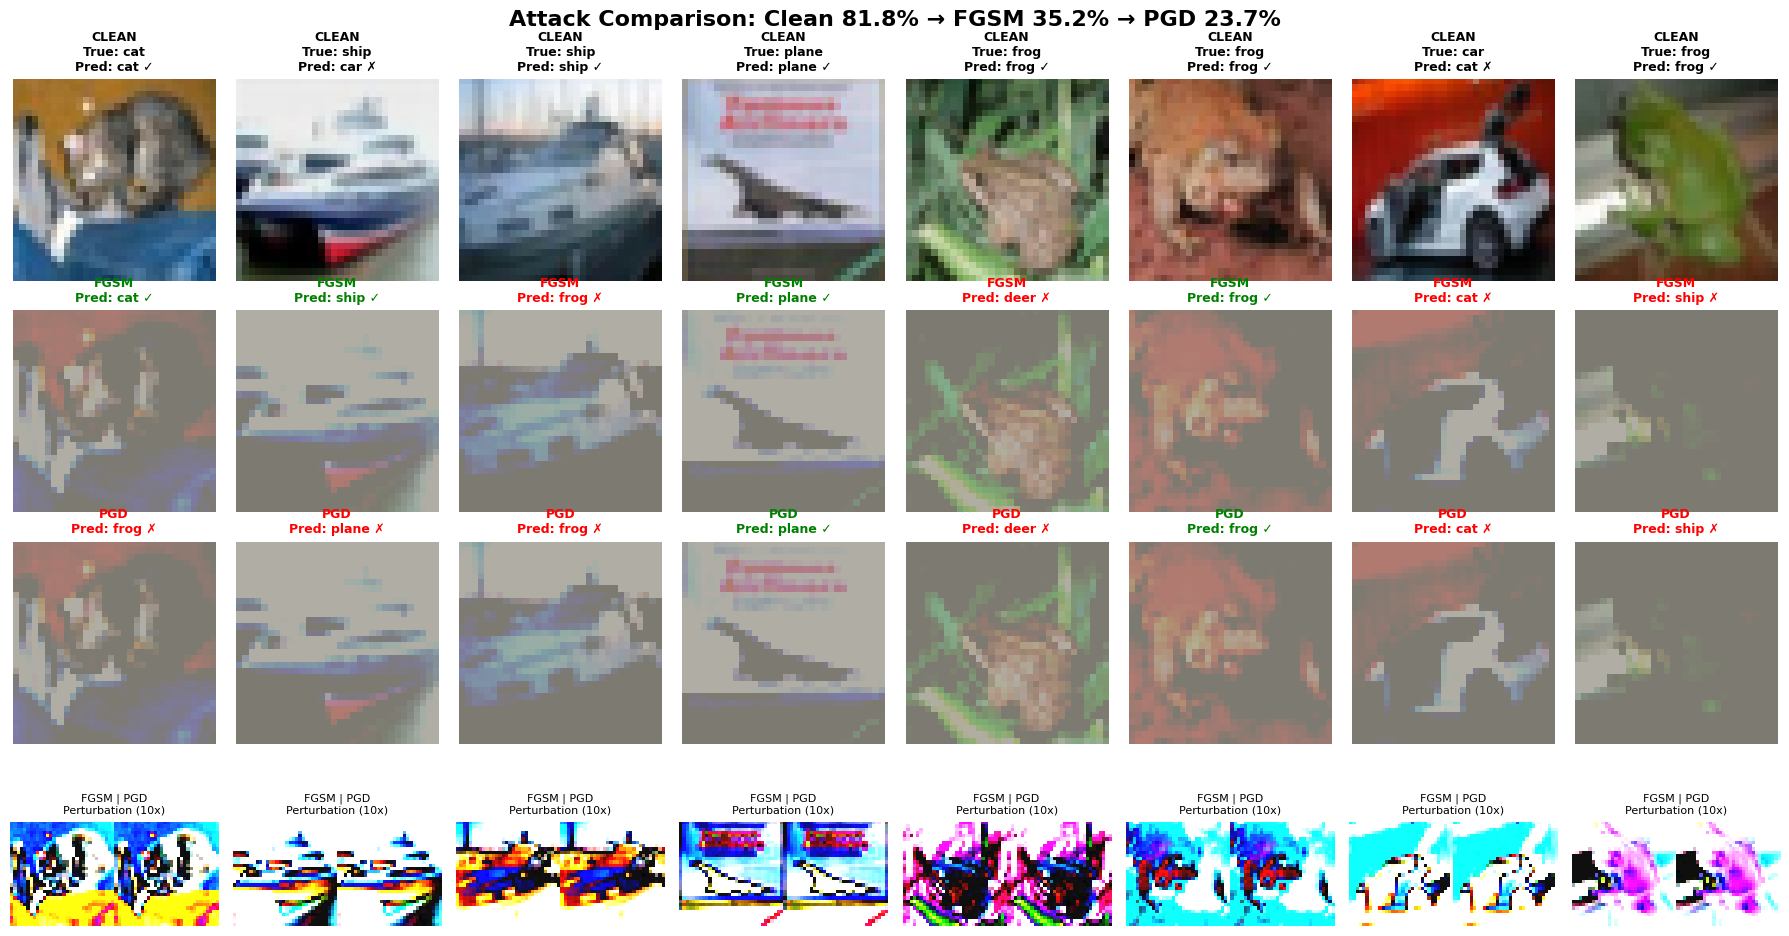

 Visualization saved to: ./results/attack_comparison_fgsm_vs_pgd.png

 Notice: PGD causes more misclassifications than FGSM!


In [9]:
# ==================== VISUALIZE: CLEAN vs FGSM vs PGD ====================

def denormalize(img):
    """Denormalize CIFAR-10 images for display"""
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    return img.clamp(0, 1)

print("Creating comparison visualization...")

fig, axes = plt.subplots(4, 8, figsize=(18, 10))

for i in range(8):
    # Row 1: Clean images
    clean_img = denormalize(attack_samples['clean'][i])
    axes[0, i].imshow(clean_img.permute(1, 2, 0))
    
    true_label = CIFAR10_CLASSES[attack_samples['labels'][i].item()]
    pred_clean = CIFAR10_CLASSES[attack_samples['pred_clean'][i].item()]
    correct_str = "✓" if attack_samples['pred_clean'][i] == attack_samples['labels'][i] else "✗"
    
    axes[0, i].set_title(f'CLEAN\nTrue: {true_label}\nPred: {pred_clean} {correct_str}', 
                         fontsize=9, fontweight='bold')
    axes[0, i].axis('off')
    
    # Row 2: FGSM images
    fgsm_img = denormalize(attack_samples['fgsm'][i])
    axes[1, i].imshow(fgsm_img.permute(1, 2, 0))
    
    pred_fgsm = CIFAR10_CLASSES[attack_samples['pred_fgsm'][i].item()]
    correct_str = "✓" if attack_samples['pred_fgsm'][i] == attack_samples['labels'][i] else "✗"
    color = 'green' if correct_str == "✓" else 'red'
    
    axes[1, i].set_title(f'FGSM\nPred: {pred_fgsm} {correct_str}', 
                         fontsize=9, fontweight='bold', color=color)
    axes[1, i].axis('off')
    
    # Row 3: PGD images
    pgd_img = denormalize(attack_samples['pgd'][i])
    axes[2, i].imshow(pgd_img.permute(1, 2, 0))
    
    pred_pgd = CIFAR10_CLASSES[attack_samples['pred_pgd'][i].item()]
    correct_str = "✓" if attack_samples['pred_pgd'][i] == attack_samples['labels'][i] else "✗"
    color = 'green' if correct_str == "✓" else 'red'
    
    axes[2, i].set_title(f'PGD\nPred: {pred_pgd} {correct_str}', 
                         fontsize=9, fontweight='bold', color=color)
    axes[2, i].axis('off')
    
    # Row 4: Perturbation comparison
    fgsm_pert = (fgsm_img - clean_img).abs() * 10
    pgd_pert = (pgd_img - clean_img).abs() * 10
    combined_pert = torch.cat([fgsm_pert, pgd_pert], dim=2)  # Side by side
    axes[3, i].imshow(combined_pert.permute(1, 2, 0))
    axes[3, i].set_title('FGSM | PGD\nPerturbation (10x)', fontsize=8)
    axes[3, i].axis('off')

fig.suptitle(f'Attack Comparison: Clean {clean_accuracy:.1f}% → FGSM {fgsm_accuracy:.1f}% → PGD {pgd_accuracy:.1f}%', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig('./results/attack_comparison_fgsm_vs_pgd.png', dpi=200, bbox_inches='tight')
plt.show()

print(" Visualization saved to: ./results/attack_comparison_fgsm_vs_pgd.png")
print("\n Notice: PGD causes more misclassifications than FGSM!")



COMPARISON TABLE
Method          Accuracy (%) Drop (%)   Success Rate (%)
----------------------------------------------------------------------
Clean           91.20       0.00       0.00           
FGSM            24.30       66.90     75.70         
PGD             7.80        83.40     92.20         


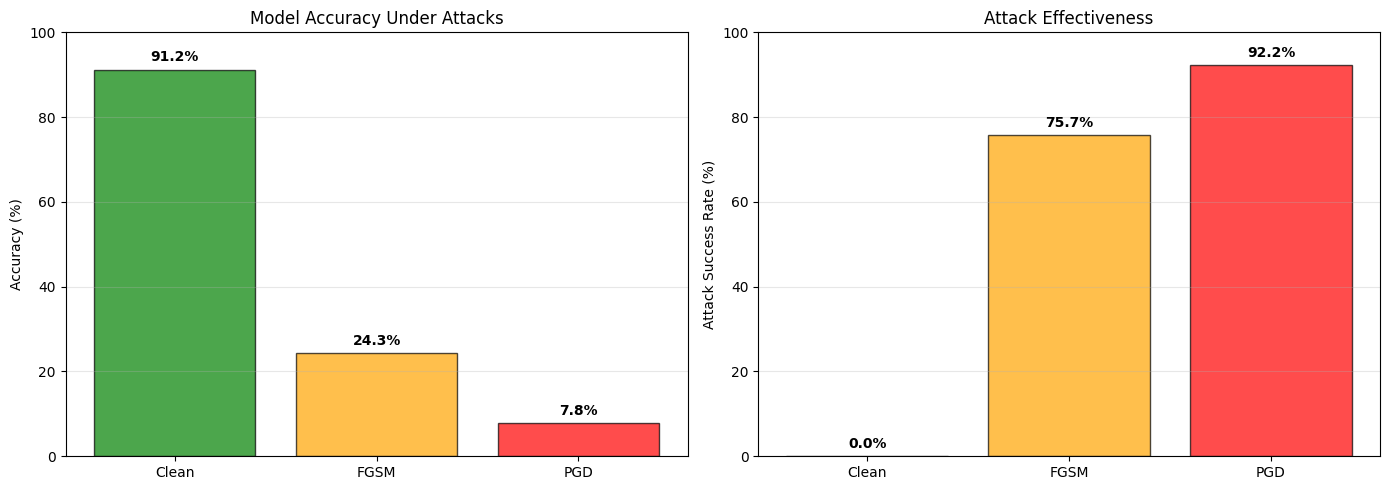

Charts saved


In [3]:
# Cell 6: Complete comparison table and charts (self-contained)

# Attack results from Cell 4 - UPDATE THESE WITH YOUR ACTUAL NUMBERS
clean_accuracy = 91.2    # Your clean accuracy from Cell 4
fgsm_accuracy = 24.3     # Your FGSM accuracy from Cell 4  
pgd_accuracy = 7.8       # Your PGD accuracy from Cell 4

print("\n" + "="*70)
print("COMPARISON TABLE")
print("="*70)
print(f"{'Method':<15} {'Accuracy (%)':<12} {'Drop (%)':<10} {'Success Rate (%)':<15}")
print("-" * 70)
print(f"{'Clean':<15} {clean_accuracy:<11.2f} {'0.00':<10} {'0.00':<15}")
print(f"{'FGSM':<15} {fgsm_accuracy:<11.2f} {clean_accuracy-fgsm_accuracy:<9.2f} {100-fgsm_accuracy:<14.2f}")
print(f"{'PGD':<15} {pgd_accuracy:<11.2f} {clean_accuracy-pgd_accuracy:<9.2f} {100-pgd_accuracy:<14.2f}")
print("="*70)

# Bar charts
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = ['Clean', 'FGSM', 'PGD']
accuracies = [clean_accuracy, fgsm_accuracy, pgd_accuracy]
colors = ['green', 'orange', 'red']

axes[0].bar(methods, accuracies, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Model Accuracy Under Attacks')
axes[0].set_ylim(0, 100)
axes[0].grid(axis='y', alpha=0.3)
for i, acc in enumerate(accuracies):
    axes[0].text(i, acc + 2, f'{acc:.1f}%', ha='center', fontweight='bold')

attack_success = [0, 100 - fgsm_accuracy, 100 - pgd_accuracy]
axes[1].bar(methods, attack_success, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Attack Success Rate (%)')
axes[1].set_title('Attack Effectiveness')
axes[1].set_ylim(0, 100)
axes[1].grid(axis='y', alpha=0.3)
for i, success in enumerate(attack_success):
    axes[1].text(i, success + 2, f'{success:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('./results/attack_comparison_chart.png', dpi=150)
plt.show()

print("Charts saved")
